In [8]:
%matplotlib widget

import sys
sys.path.append("../")

import yaml
import matplotlib.pyplot as plt
import cattrs
from typing import List
from mixture_optimization.datamodels.trial_tracking_config import Experiment, ValResult, Dict
from collections import defaultdict
import numpy as np


from law import read_experiments, parse_results, fit, optimize

In [9]:
def visualize_weighted_3d(results:Dict, best_parameters: Dict, fitting_function):
    """Only works on 3D data and one result."""
    assert len(results["results"].keys()) == 3, "Plotting only works in 3D"

    # create 3D plot
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111, projection='3d')

    key1 = list(results["results"].keys())[0]
    key2 = list(results["results"].keys())[1]
    key3 = list(results["results"].keys())[2]
    
    # Start by plotting true results --------------------
    # create weights as tuple (key1, key2)
    weights = [(r1["weight"], r2["weight"]) for r1, r2 in zip(results["results"][key1], results["results"][key2])]
    weighted_perplexity = [(x1["perplexity"] + x2["perplexity"] + x3["perplexity"]) / 3 for x1, x2, x3 in zip(results["results"][key1], results["results"][key2], results["results"][key3])]

    # plot 3D scatter
    ax.scatter([w[0] for w in weights], [w[1] for w in weights], weighted_perplexity)
    ax.set_xlabel(f"Mixing weight for {key1}")
    ax.set_ylabel(f"Mixing weight for {key2}")
    ax.set_zlabel("Weighted perplexity")
    
    # plot fit -------------------------------------------
    def weighted_sum_func(domain_weights: List[float]):
        sum = 0
        for domain_weight, domain_parameters in zip(domain_weights, best_parameters.values()):
            sum += fitting_function(domain_weight, *domain_parameters)
        sum /= len(domain_weights)
        return sum

    # create x,y grid
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = 1 - X - Y

    val = np.array([weighted_sum_func([x1, x2, x3]) for x1, x2, x3 in zip(X.flatten(), Y.flatten(), Z.flatten())])
    Z = val.reshape(X.shape)

    ax.plot_surface(X, Y, Z, alpha=0.5)


{'Books': array([4.06201743, 0.06136096]), 'CC': array([4.51788667, 0.06288045]), 'stack-v4': array([2.3069031 , 0.27325697])}
Best weights: ['Books: 0.20716772142809284', 'CC: 0.23486562523981402', 'stack-v4: 0.5579666533320932'], predicted value: 4.042798296354603


/tmp/ipykernel_771673/2152685728.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return B/ (r**b)
/tmp/ipykernel_771673/2152685728.py:6: RuntimeWarning: invalid value encountered in scalar power
  return B/ (r**b)


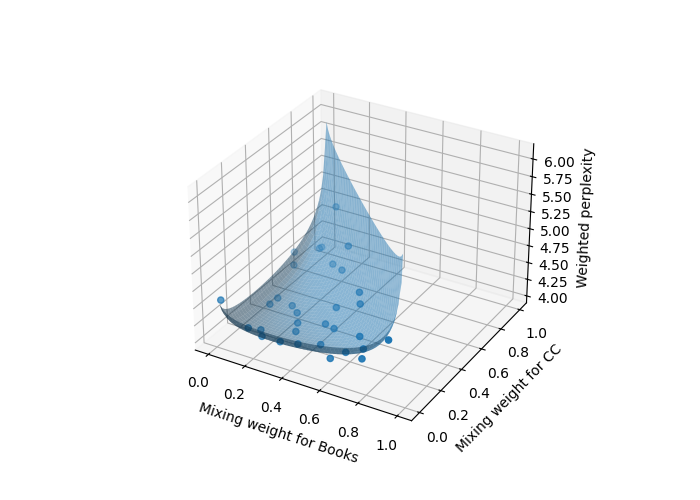

In [10]:
path = "/root/code/mixture_optimization/logs/uniform_books_cc_stack_0/experiment_history.yaml"
experiments = read_experiments(path)
experiment = experiments[0]

def func(r, B, b):
    return B/ (r**b)

best_parameters, results = fit(experiment, func, region=(0.1, 0.9))
best_weights, pred_value = optimize(func, best_parameters)

domain_names = list(best_parameters.keys())
weight_str = [f"{name}: {weight}" for (name, weight) in zip(domain_names, best_weights)]
print(f"Best weights: {weight_str}, predicted value: {pred_value}")

results = parse_results(experiment, -1)
visualize_weighted_3d(results, best_parameters, func)